# Проект для HR компании "Работа с заботой"

**Цель:** помочь бизнесу оптимизировать управление персоналом чтобы избежать финансовых потерь и оттока сотрудников. 

Для этого нужно выполнить две задачи:  
1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

    **План исследования:**
 * Загрузка и знакомство с данными.
 * Предобработка данных, работа с пропусками и дубликатами.
 * Исследовательский анализ данных.
 * Подготовка данных.
 * Обученние моделей, выбор лучшей.
 * Вывод
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

    **План исследования:**
 * Загрузка и знакомство с данными.
 * Предобработка данных, работа с пропусками и дубликатами.
 * Исследовательский анализ данных.
 * Добавление нового входного признака.
 * Подготовка данных.
 * Обученние моделей, выбор лучшей.
 * Вывод


# Описание данных

**Задача 1**   
`id` — уникальный идентификатор сотрудника;  
`dept` — отдел, в котором работает сотрудник;  
`level` — уровень занимаемой должности;   
`workload` — уровень загруженности сотрудника;   
`employment_years` — длительность работы в компании (в годах);   
`last_year_promo` — показывает, было ли повышение за последний год;   
`last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;   
`supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;   
`salary` — ежемесячная зарплата сотрудника;   
`job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, ***целевой признак***.
- **`train_job_satisfaction_rate.csv`** - тренировочная выборка;
- **`test_features.csv`** - входные признаки тестовой выборки;
- **`test_target_job_satisfaction_rate.csv`** - целевой признак тестовой выборки.

**Задача 2**   
`id` — уникальный идентификатор сотрудника;  
`dept` — отдел, в котором работает сотрудник;  
`level` — уровень занимаемой должности;   
`workload` — уровень загруженности сотрудника;   
`employment_years` — длительность работы в компании (в годах);   
`last_year_promo` — показывает, было ли повышение за последний год;   
`last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;   
`supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;   
`salary` — ежемесячная зарплата сотрудника;  
`quit`- информация уволился сотрудник или нет, ***целевой признак***.
- **`train_quit.csv`** - тренировочная выборка;
- **`test_features.csv`** - входные признаки тестовой выборки;
- **`test_target_quit.csv`** - целевой признак тестовой выборки;

# Задача 1

## Шаг 1. Загрузка данных.

In [1]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [2]:
!pip install phik -q
!pip install shap -q
!pip install -Uq scikit-learn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from scipy.stats import ttest_ind
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.linear_model import LinearRegression,LogisticRegression 
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance

In [4]:
import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix

import shap

In [5]:
!pip list

Package                           Version
--------------------------------- -------------------
absl-py                           1.2.0
alembic                           1.6.5
anyio                             3.2.1
argon2-cffi                       20.1.0
astunparse                        1.6.3
async-generator                   1.10
attrs                             21.2.0
Babel                             2.9.1
backcall                          0.2.0
backports.functools-lru-cache     1.6.4
beautifulsoup4                    4.9.3
bleach                            3.3.0
blinker                           1.4
blis                              0.7.8
branca                            0.5.0
brotlipy                          0.7.0
cachetools                        5.2.0
catalogue                         2.0.8
catboost                          1.0.3
certifi                           2022.6.15
certipy                           0.1.3
cffi                              1.14.5
chardet             

In [6]:
try:
    train_job = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/Сборный проект 2/train_job_satisfaction_rate.csv')
    test_f = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/Сборный проект 2/test_features.csv')
    target_job = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/Сборный проект 2/test_target_job_satisfaction_rate.csv')
except:
    train_job = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    test_f = pd.read_csv('/datasets/test_features.csv')
    target_job = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
    
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)

display(train_job.head(5))
display(test_f.head(5))
display(target_job.head(5))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.580
1,653870,hr,junior,high,2,no,no,5,38400,0.760
2,184592,sales,junior,low,1,no,no,2,12000,0.110
3,171431,technology,junior,low,4,no,no,2,18000,0.370
4,693419,hr,junior,medium,1,no,no,3,22800,0.200


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,job_satisfaction_rate
0,130604,0.740
1,825977,0.750
2,418490,0.600
3,555320,0.720
4,826430,0.080


In [7]:
train_job.info()
test_f.info()
target_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----

#### Промежуточный вывод

**Цель:** загрузить данные и ознакомиться с общей информацией датафреймов.  
**Результаты:**
1) Установили объем данных: 
- `train_job` 10 столбцов, 4000 строк.
- `test_f` 9 столбца, 2000 строк.
- `target_job` 2 столбцa, 2000 строк.

2) Проблем с разделением данных не обнаружено, по информации о датафреймах видно, что в `train_job` и `test_f` имеются пропуски.

## Шаг 2. Предобработка данных.

In [8]:
print(train_job.dtypes)
print(test_f.dtypes)
print(target_job.dtypes)

id                         int64
dept                      object
level                     object
workload                  object
employment_years           int64
last_year_promo           object
last_year_violations      object
supervisor_evaluation      int64
salary                     int64
job_satisfaction_rate    float64
dtype: object
id                        int64
dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
dtype: object
id                         int64
job_satisfaction_rate    float64
dtype: object


Типы данных в порядке. Категориальные признаки имеют тип данных object, количественные int/float. Проверим данные на явные дубликаты, сразу переведем `id`  в индекс, так нам будет удобнее работать.

In [9]:
train_job.set_index('id', inplace=True)
test_f.set_index('id', inplace=True)
target_job.set_index('id', inplace=True)
print(f'Количество выявленных явных дубликатов тестовой выборки: {train_job.duplicated().sum()}')
print(f'Количество выявленных явных дубликатов тренировочной выборки: {test_f.duplicated().sum()}')
print(f'Количество выявленных явных дубликатов целевого признака: {target_job.duplicated().sum()}')

Количество выявленных явных дубликатов тестовой выборки: 245
Количество выявленных явных дубликатов тренировочной выборки: 557
Количество выявленных явных дубликатов целевого признака: 1902


Нас волнуют только дубликаты в тренировочной выборке, так как на них модель будет обучаться и дубликаты ее "запутают". Поэтому удалим дубликаты у тестовой выборки.

In [10]:
train_job = train_job.drop_duplicates()
train_job.shape

(3755, 9)

Проверим на неявные дубликаты.

In [11]:
columns_to_print = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]

for column in columns_to_print:
        unique_values = train_job[column].unique().tolist()
        print(f'Уникальные значения в {column}: {unique_values}')

Уникальные значения в dept: ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan]
Уникальные значения в level: ['junior', 'middle', 'sinior', nan]
Уникальные значения в workload: ['medium', 'high', 'low']
Уникальные значения в last_year_promo: ['no', 'yes']
Уникальные значения в last_year_violations: ['no', 'yes']


In [12]:
for column in columns_to_print:
        unique_values = test_f[column].unique().tolist()
        print(f'Уникальные значения в {column}: {unique_values}')

Уникальные значения в dept: ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' ']
Уникальные значения в level: ['junior', 'middle', 'sinior', nan]
Уникальные значения в workload: ['medium', 'low', 'high', ' ']
Уникальные значения в last_year_promo: ['no', 'yes']
Уникальные значения в last_year_violations: ['no', 'yes']


В датафрейме `test_f` обнаружены значения пробела. Посмотрим на строки с этими значениямми.

In [13]:
print(display(test_f.query("dept == ' ' or workload == ' '")))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
590867,marketing,junior,,4,no,no,4,28800
822186,,middle,medium,3,no,no,4,38400


None


Обрабатаем пробелы с другими пропусками в дальнейших шагах. Нам важно сохранить размер датафрейма исходным, поэтому не принимаю решения удалить строки.

In [14]:
print(display(test_f[test_f['dept'].isnull() | test_f['workload'].isnull()| test_f['level'].isnull()]))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
609865,NaN,junior,medium,1,no,no,1,20400
471990,sales,NaN,low,1,no,no,3,12000
832342,NaN,junior,medium,1,no,no,4,28800


None


В датафрейме `test_f` обнаружено 5 пропусков.

In [15]:
print(display(train_job[train_job['dept'].isnull() |train_job['level'].isnull()]))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
631073,sales,NaN,medium,1,no,no,4,27600,0.660
416327,sales,NaN,low,1,no,no,5,18000,0.730
694746,NaN,junior,medium,5,no,no,4,21600,0.620
814624,NaN,junior,medium,3,no,no,4,24000,0.880
475114,NaN,junior,high,4,no,no,4,31200,0.630
135043,sales,NaN,medium,1,no,no,3,26400,0.300
998838,sales,NaN,medium,1,no,no,5,27600,0.710
497243,NaN,junior,medium,1,no,no,3,26400,0.280
168668,NaN,junior,low,3,no,no,4,18000,0.880


None


В датафрейме `train_job` обнаружено 10 пропусков.

Пропуски в датафреймах `train_job` и `test_f` заполним в пайплайне позже при помощи SimpleImputer.

#### Промежуточный вывод

**Цель:** выполнить предобработку данных.  
**Задачи:**
1. Проверка типов данных.
2. Выявление и обработка явных и неявных дубликатов.
3. Выявление пропусков.

**Результаты**

1) Проверка и исправление типов данных:
- Типы данных корректные.

2) Выявление и обработка явных и неявных дубликатов:
-  Выявлены явные дубликаты во всех датафреймов, удалены только у датафрейма `train_job`
- Выявлены неявные дубликат в категориальных столбцах "dept" и "workload" датафрейма `test_f`.

3) Выявление пропусков:
- Выявлены пропуски в столбцах "dept" и "level" датафреймов `train_job` и `test_f`, также в датафрейме `test_f` в столбце `workload`.
- Принято решение заполнить пропуски инструментом SimpleImputer в будущем при подготовке даных.

## Шаг 3. Исследовательский анализ данных.

Используем функции для исследования данных.

In [16]:
def categorical_features(df, attribute, title, hue=None):
    '''
    Plots for categorical attributes with an optional hue for segmentation
        Parameters:
            df: Dataframe
            attribute: Column with attribute
            title: Title of graphs
            hue: Optional; column for target segmentation
            
    Returns:
        Series: number of unique values
        plot: pie chart and countplot
    '''
    counts = df[attribute].value_counts(ascending=False)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    wedges, texts, autotexts = ax1.pie(counts, labels=counts.index, autopct='%1.1f%%',
                                       startangle=90, colors=sns.color_palette('afmhot_r', len(counts)))
    plt.setp(autotexts, size=12, weight='bold', color='black')
    plt.setp(texts, size=12)
    ax1.set_title(title, fontsize=16, fontweight='bold')

    sns.countplot(x=attribute, data=df, palette='afmhot_r', ax=ax2, hue=hue)
    ax2.set_title(title, fontsize=16, fontweight='bold')
    ax2.set_xlabel(attribute)
    ax2.set_ylabel('Частота')
    ax2.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()
    sns.set(rc={
    'figure.figsize': (10, 7.5),
    'axes.labelsize': 12,  
    'xtick.labelsize': 10, 
    'ytick.labelsize': 10,  
    })
    print(counts)

def quantitative_features(df, attribute, title, hue=None, bins=20):
    '''
    Plots for quantitative attributes
        Parameters:
            df: DataFrame
            attribute: Column with attribute
            title: Title of graphs
            hue: Optional, column for target segmentation
            bins: Number of bins for the histogram
            
    Returns:
        None
    '''
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    if hue and hue in df.columns:
        sns.histplot(df, x=attribute, hue=hue, kde=True, bins=bins, ax=ax[0], multiple="dodge", palette="Set2")
    else:
        sns.histplot(df[attribute], kde=True, bins=bins, ax=ax[0], palette="Set2")

    ax[0].set_title('Гистограмма', fontsize=18)
    ax[0].set_xlabel(title, fontsize=15)
    
    sns.boxplot(x=attribute, data=df, ax=ax[1], palette="Set2", hue=hue)
    ax[1].set_title('Ящик с усами', fontsize=18)
    ax[1].set_xlabel(title, fontsize=15)
    
    sns.set(rc={'figure.figsize': (10, 7.5),
    'axes.labelsize': 12,  
    'xtick.labelsize': 10, 
    'ytick.labelsize': 10,
    })
    fig.suptitle(title, fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print(df[attribute].describe().T)

**Исследование категориальных признаков**

Исследуем тренирововчную выборку.

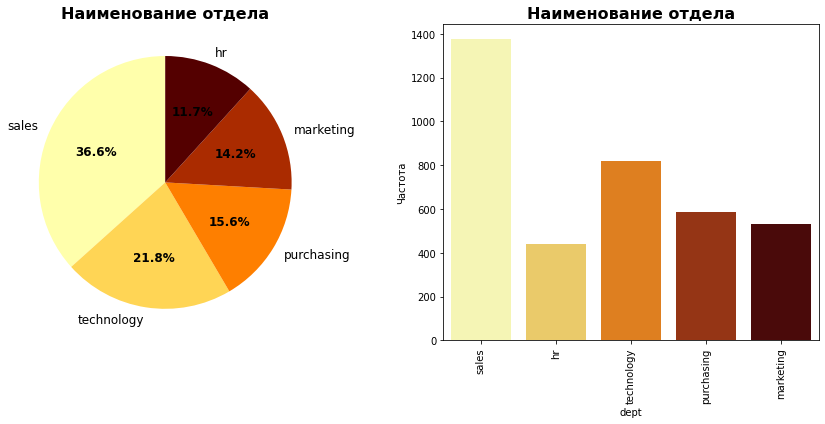

sales         1374
technology     818
purchasing     586
marketing      531
hr             440
Name: dept, dtype: int64


In [17]:
categorical_features(train_job, 'dept', 'Наименование отдела')

Наибольшая доля сотрудников компании сосредоточена в отделе продаж — 37.9%. Отдел технологий занимает второе место, объединяя 21.7 персонала. Наименьшее количество сотрудников работает в отделе HR, на его долю приходится всего 11,5%.

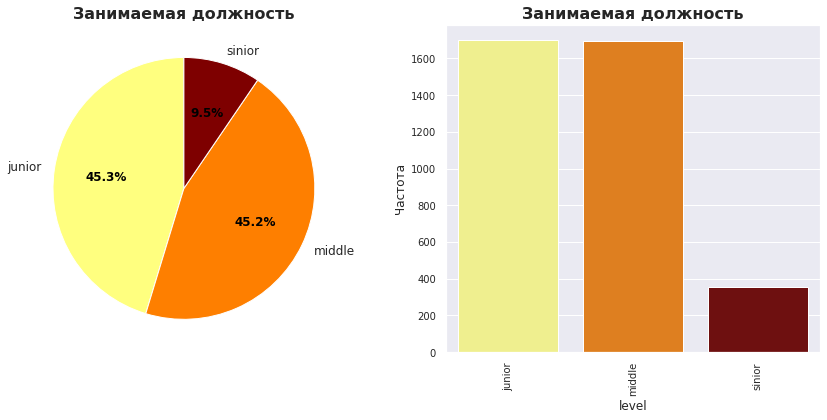

junior    1699
middle    1695
sinior     357
Name: level, dtype: int64


In [18]:
categorical_features(train_job, 'level', 'Занимаемая должность')

Наиболее многочисленная группа сотрудников juniorm, следом middle, наименее многочесленная sinior - 9%.

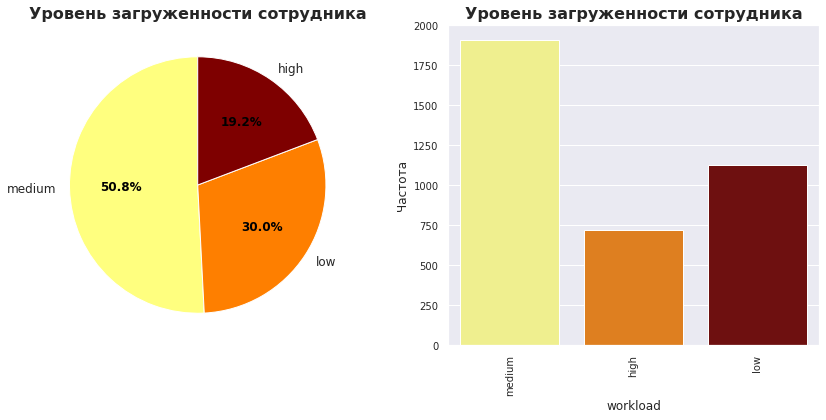

medium    1908
low       1125
high       722
Name: workload, dtype: int64


In [19]:
categorical_features(train_job, 'workload', 'Уровень загруженности сотрудника')

Более половины (51.6%) сотрудников имеют средний уровень загруженности, 30% низкую и всего 18.4% высокую.

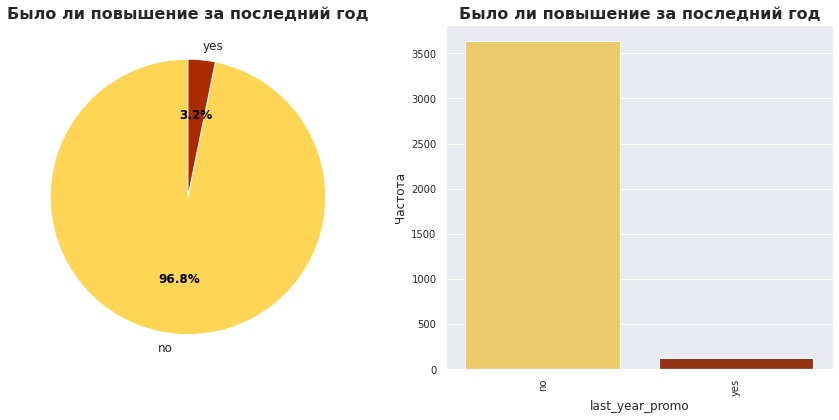

no     3635
yes     120
Name: last_year_promo, dtype: int64


In [20]:
categorical_features(train_job, 'last_year_promo', 'Было ли повышение за последний год')

97% сотрудников не получали повышение за последний год.

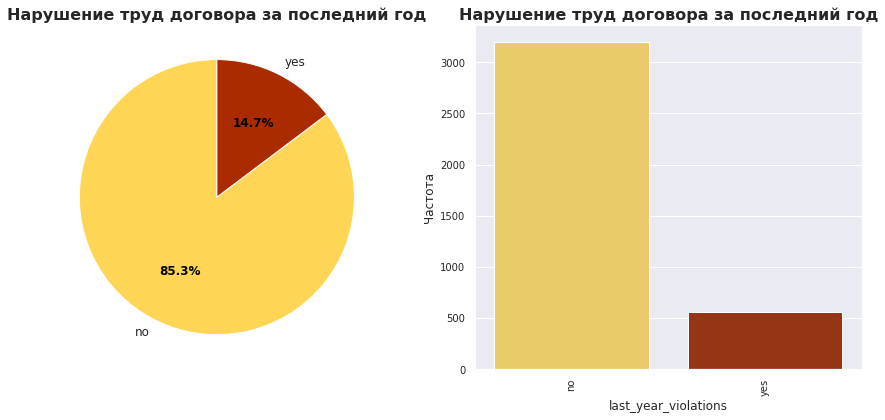

no     3202
yes     553
Name: last_year_violations, dtype: int64


In [21]:
categorical_features(train_job, 'last_year_violations', 'Нарушение труд договора за последний год')

86% сотрудников не нарушали трудовой договор за последний год.

Исследуем входные признаки тестовой выборки.

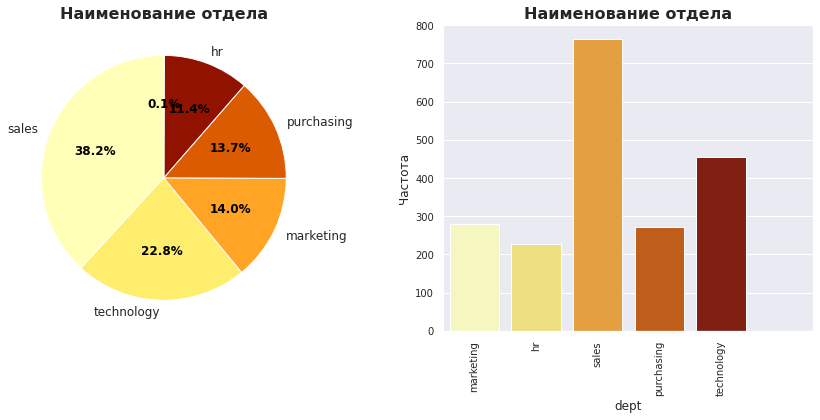

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64


In [22]:
categorical_features(test_f, 'dept', 'Наименование отдела')

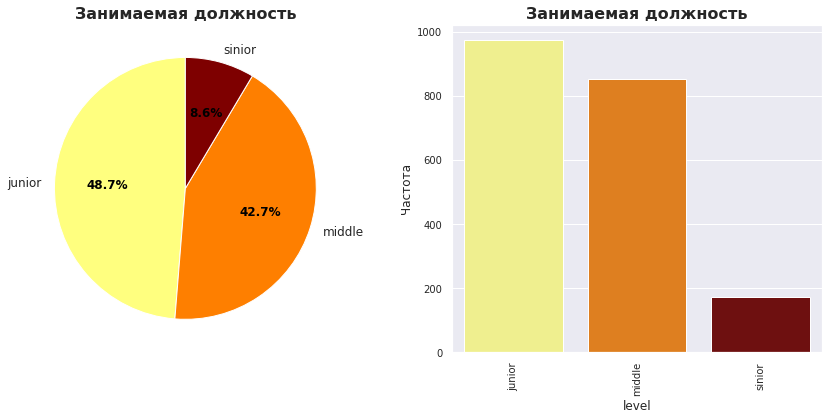

junior    974
middle    854
sinior    171
Name: level, dtype: int64


In [23]:
categorical_features(test_f, 'level', 'Занимаемая должность')

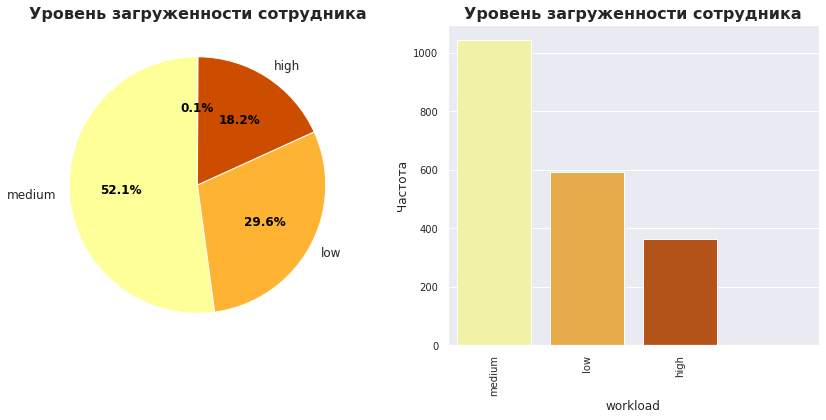

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64


In [24]:
categorical_features(test_f, 'workload', 'Уровень загруженности сотрудника')

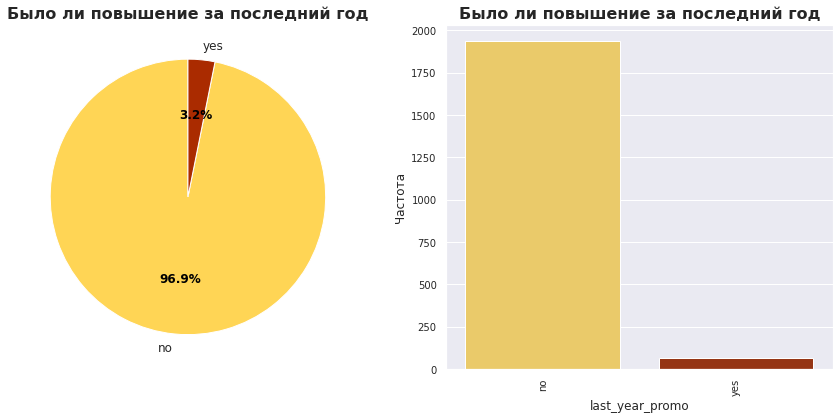

no     1937
yes      63
Name: last_year_promo, dtype: int64


In [25]:
categorical_features(test_f, 'last_year_promo', 'Было ли повышение за последний год')

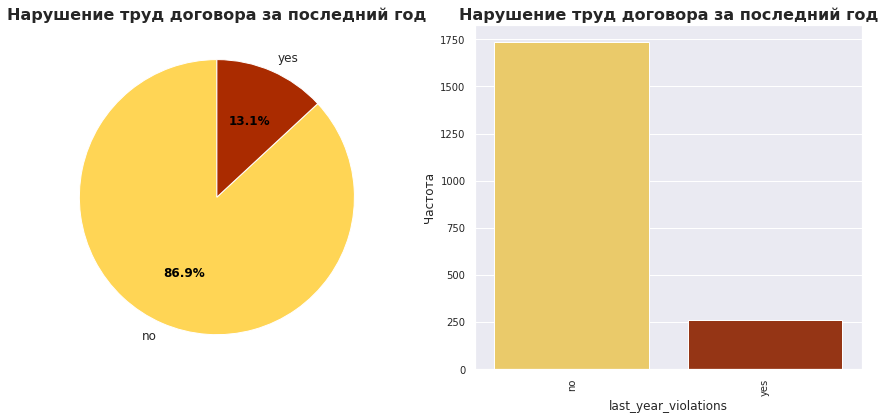

no     1738
yes     262
Name: last_year_violations, dtype: int64


In [26]:
categorical_features(test_f, 'last_year_violations', 'Нарушение труд договора за последний год')

Соотношения похожи на тренировочную выборку, с входными категориальными признаками тестовой выборки все в порядке.

**Исследование количественных признаков**

Исследуем тренировочную выборку.

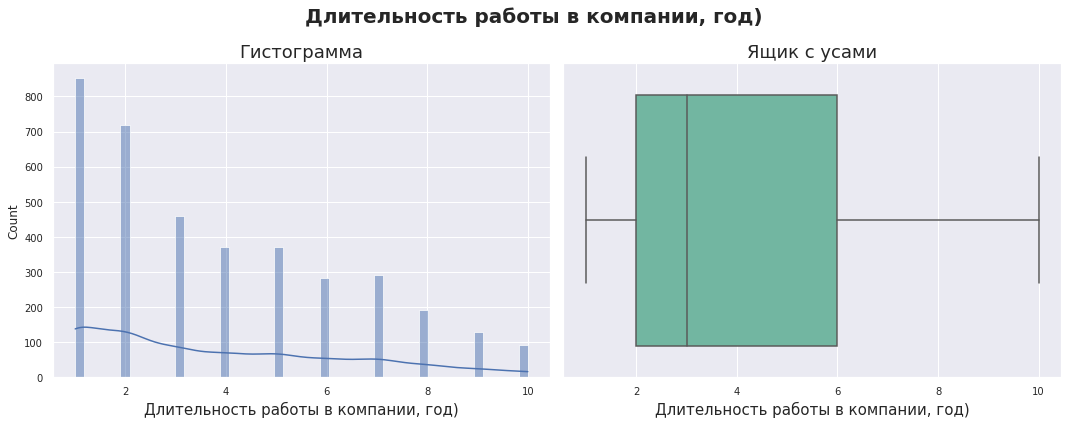

count   3,755.000
mean        3.817
std         2.557
min         1.000
25%         2.000
50%         3.000
75%         6.000
max        10.000
Name: employment_years, dtype: float64


In [27]:
quantitative_features(train_job,'employment_years','Длительность работы в компании, год)', bins=50)

Наибольшее количество сотрудников работает в компании 1год, среднее и медианное значение равно 3, максимальный стаж у сотрудников равен 10. Возможно, что компания относительно молодая.

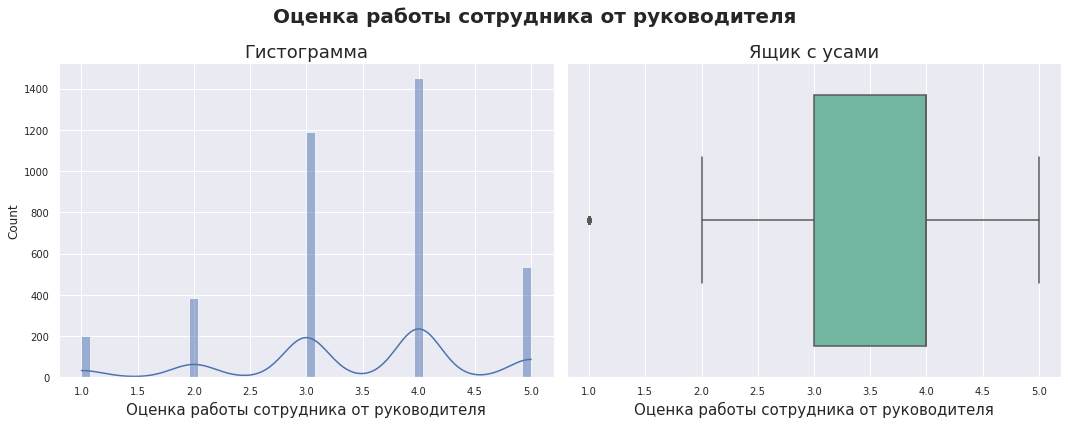

count   3,755.000
mean        3.464
std         1.026
min         1.000
25%         3.000
50%         4.000
75%         4.000
max         5.000
Name: supervisor_evaluation, dtype: float64


In [28]:
quantitative_features(train_job,'supervisor_evaluation','Оценка работы сотрудника от руководителя', bins=50)

Работу сотрудников оценивают по 5-бальной шкале. Средняя оценка равна 3,5, медианное значение 4, оно же является самой частой оценкой. Имеется так же выброс в редком значении 1 бал.

In [29]:
len(train_job.query('supervisor_evaluation == 1'))

198

198 сотрудник имеет оценику равную 1, запомним это.

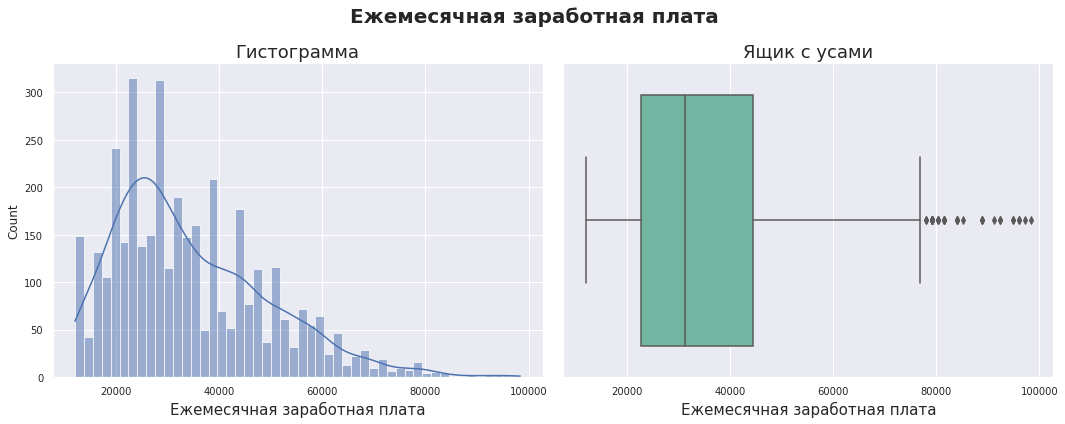

count    3,755.000
mean    34,457.417
std     15,050.644
min     12,000.000
25%     22,800.000
50%     31,200.000
75%     44,400.000
max     98,400.000
Name: salary, dtype: float64


In [30]:
quantitative_features(train_job,'salary','Ежемесячная заработная плата', bins=50)

Минимальная заработная плата составляет 12000, макимальная 98400. Среднее и медиана недалеко друг от друга, 33926 и 300000. Большинство зарплат составляют от 23000 до 43000. Гистограмма сильно скошена вправо, имеется ряд должностей у которых зарплата выше средних значений, более 75000. Однако, при анализе боксплота, эти повышенные значения рассматриваются как выбросы, хотя по сути они не являются реальными выбросами, а отражают особенности распределения заработных плат.

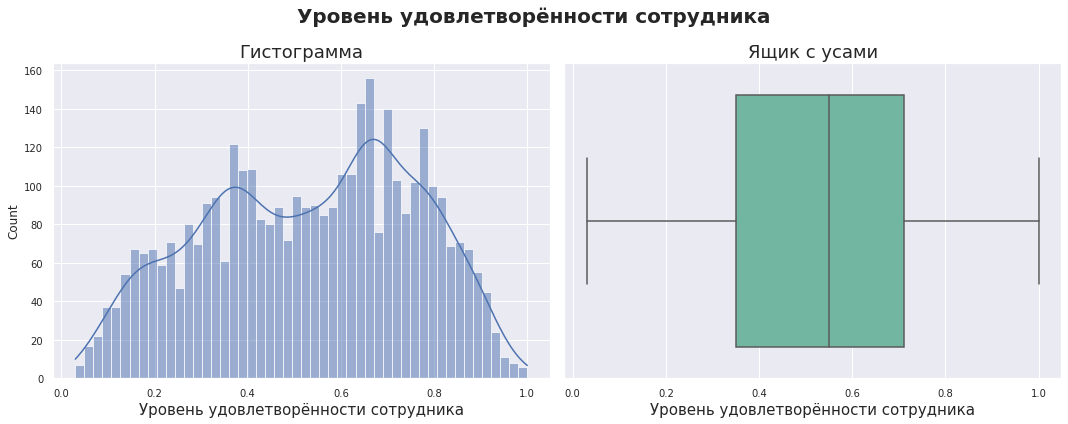

count   3,755.000
mean        0.533
std         0.226
min         0.030
25%         0.350
50%         0.550
75%         0.710
max         1.000
Name: job_satisfaction_rate, dtype: float64


In [31]:
quantitative_features(train_job,'job_satisfaction_rate','Уровень удовлетворённости сотрудника', bins=50)

Среднее и медианное значение удовлетворенности сотрудников составляют 0.5. Анализируя межквартильный размах, можно увидеть, что большинство работников демонстрируют удовлетворение условиями труда в диапазоне от 0.35 до 0.71. В целом, эти показатели указывают на то, что уровень удовлетворенности сотрудников можно считать скорее низким.

Исследуем входные признаки тестовой выборки.

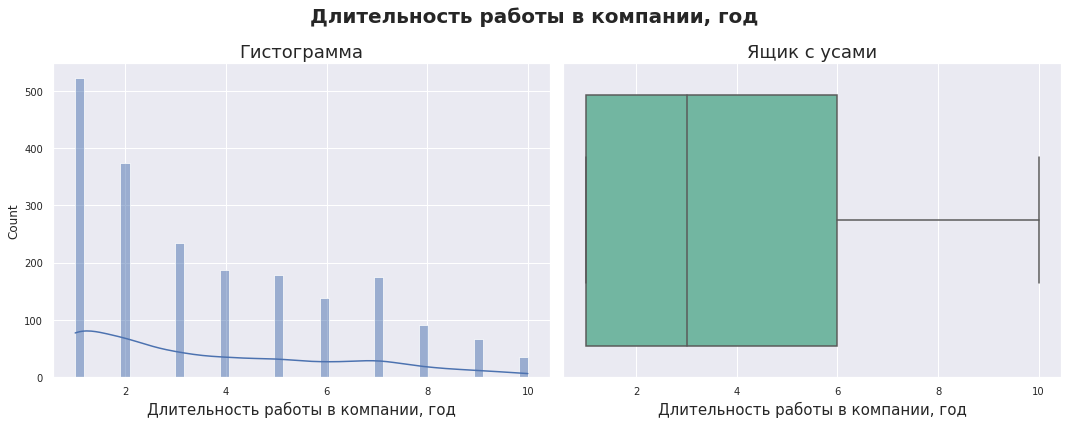

count   2,000.000
mean        3.667
std         2.537
min         1.000
25%         1.000
50%         3.000
75%         6.000
max        10.000
Name: employment_years, dtype: float64


In [32]:
quantitative_features(test_f,'employment_years','Длительность работы в компании, год', bins=50)

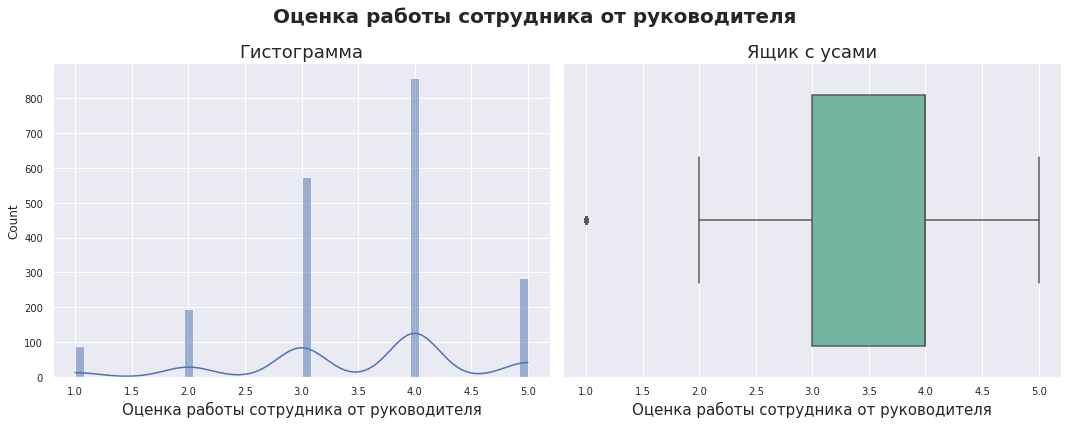

count   2,000.000
mean        3.526
std         0.997
min         1.000
25%         3.000
50%         4.000
75%         4.000
max         5.000
Name: supervisor_evaluation, dtype: float64


In [33]:
quantitative_features(test_f,'supervisor_evaluation','Оценка работы сотрудника от руководителя', bins=50)

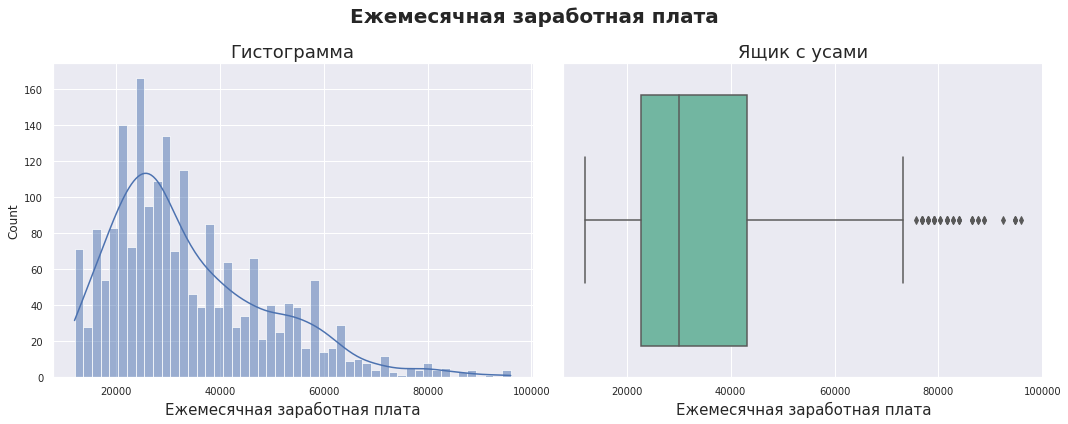

count    2,000.000
mean    34,066.800
std     15,398.437
min     12,000.000
25%     22,800.000
50%     30,000.000
75%     43,200.000
max     96,000.000
Name: salary, dtype: float64


In [34]:
quantitative_features(test_f,'salary','Ежемесячная заработная плата', bins=50)

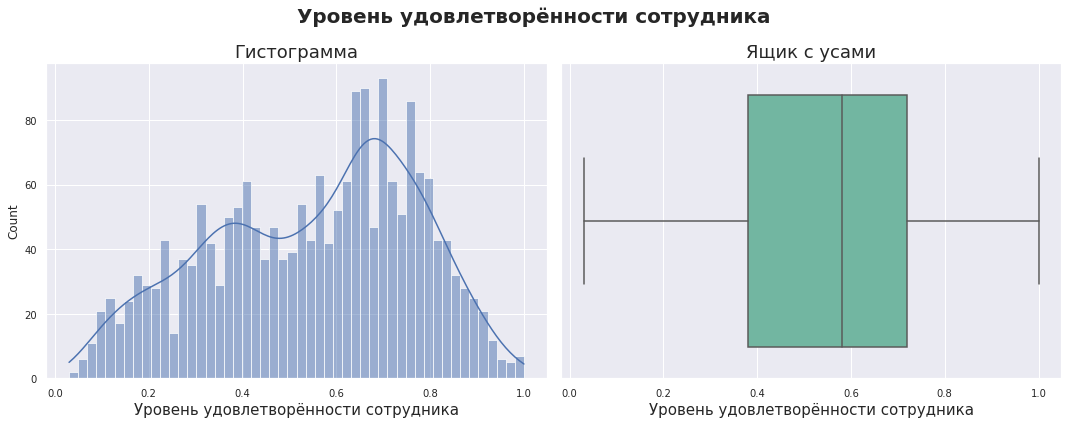

count   2,000.000
mean        0.549
std         0.220
min         0.030
25%         0.380
50%         0.580
75%         0.720
max         1.000
Name: job_satisfaction_rate, dtype: float64


In [35]:
quantitative_features(target_job,'job_satisfaction_rate','Уровень удовлетворённости сотрудника', bins=50)

Соотношения похожи на тренировочную выборку, с входными категориальными признаками тестовой выборки все в порядке.

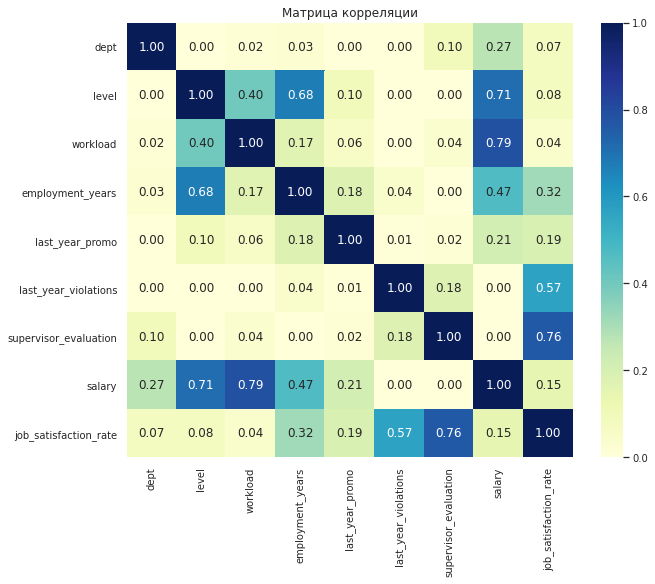

In [36]:
interval_cols = ['salary', 'job_satisfaction_rate']
plt.figure(figsize=(10, 8))
sns.heatmap(train_job.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Матрица корреляции')
plt.show()

Целевой признак имеет сильную взаимосвязь с оценкой работы сотрудника от руководителя и умееренную связь с тем было ли нарушение трудового договора за последний год работы. Заработная плата имеет сильную взаимосвязь с уровнем рабочей нагрузки, уровнем должности , умеренную связь со стажем работы в компании.  
Мультиколлинеарность отсутсвует.

<Figure size 720x432 with 0 Axes>

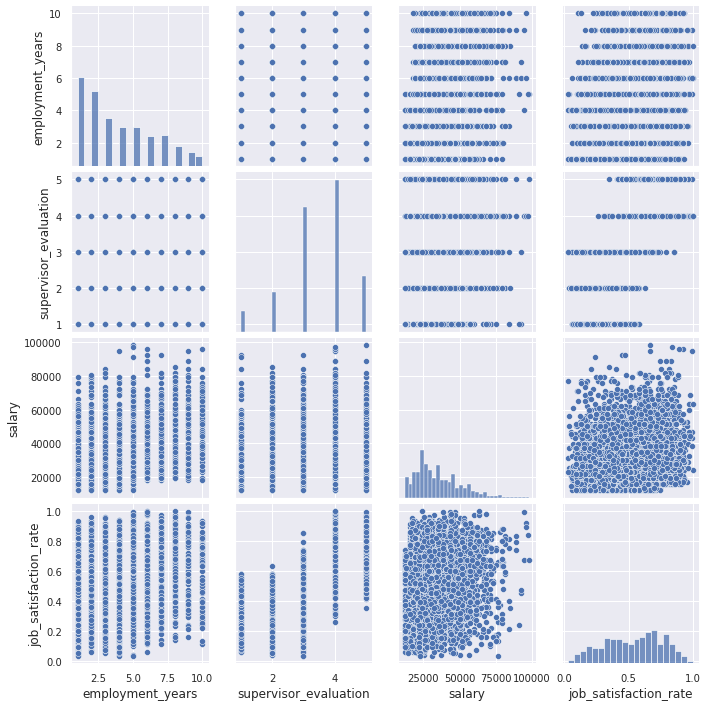

In [37]:
plt.figure(figsize=(10, 6))
sns.pairplot(train_job, markers=["o", "s"])

plt.show()

По данной матрице видно, что оценка сотрудиков их удовлетворенности работой не имеет линейной зависимости от размера заработной платы.

#### Промежуточный вывод

**Цель:** провести исследовательский анализ данных.  
**Задачи:**
1. Провести статистический анализ данных.

**Результаты**

1) Провести статистический анализ данных:
- При исследовании категориальных данных выявилось, что 97% сотрудников не получали повышения за последний год, не нарушали трудовой договор, работают в отделе продаж или технологическом на должности джуниор или мидл.
- При исследовании количественных данных выявилось, что большинство сотрудников получают зарплату от 20 до 40 тыс.р., работают 1-2 года, руководство ценивает работу сотрудников как удовлетворительную и хорошую, и сотрудники удовлетворены условиями труда в среднем на 0.56.
- Распределения тестовой выборки похожи на тренировочную.
- Целевой признак имеет сильную взаимосвязь с оценкой работы сотрудника от руководителя и умееренную связь с тем было ли нарушение трудового договора за последний год работы. 
- Мультиколлинеарность не выявлена.

## Шаг 4. Подготовка данных.

Первым делом создадим списки для кодирования и масштабирования данных. Целевой признак не нужно кодировать или масштабировать, так как он уже находится в подходящем диапазоне и соответствует требованиям регрессионных моделей.
Для категориальных признаков будем использовать OneHotEncoder и OrdinalEncoder, для количественных MinMaxScaler и StandartScaler. Так же нам нужно заполнить пропуски SimpleImputer.

In [38]:
ohe_columns = [
    'dept', 
    'last_year_promo',
    'last_year_violations'
]
ord_columns = [
    'level',
    'workload'
]
num_columns = [ 
    'supervisor_evaluation',
    'employment_years',
    'salary'
]

Оформим выборки.

In [39]:
X_train = train_job.drop('job_satisfaction_rate', axis=1)
y_train = train_job['job_satisfaction_rate']

test_data = test_f.merge(target_job, on='id')

X_test = test_data.drop('job_satisfaction_rate', axis=1)
y_test = test_data['job_satisfaction_rate']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3755, 8)
(2000, 8)
(3755,)
(2000,)


In [41]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[
                ['junior', 'middle', 'senior'],
                ['high', 'medium', 'low']
            ],
            handle_unknown='use_encoded_value',
            unknown_value=np.nan
        )),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [42]:
import sklearn
sklearn.__version__

'1.6.1'

#### Промежуточный вывод

**Цель:** провести подготовку данных.  
**Задачи:**
1. Применить кодирование и масштабирование.
2. Создать пайплайн.

**Результаты**

1) Применить кодирование и масштабирование: 
- Для категориальных признаков применены кодировщики `OneHotEncoder` и `OrdinalEncoder`.
- Для количественных признаков применено масштабирование `StandardScaler` и `MinMaxScaler`.
- Проведено разбитие выборок на тестовую и тренирововчную соответсвующей размерности.

2) Создать пайплайн:
- Создан пайплайн `data_preprocessor` c SimpleImputer для заполнения пропусков у категориальных данных модой.

## Шаг 5. Обучение модели.

Перед нами стоит задача регресси, используем `LinearRegression` без настройки гиперпараметров, и `DecisionTreeRegressor` c гиперпараметрами - минимальное количество образцов, необходимое для нахождения в листовом узле каждого дерева, минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться, максимальную глубина дерева. Выбор лучшей модели и оценку будем проводить метрикой SMAPE. Нам нужно выборать модель у которой SMAPE будет менее 15%. Подбор парамемтров осуществлен `GridSearchCV`.

In [43]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('classifier', LinearRegression())
    ]
) 


param_grid =[
    {
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'classifier': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_split': range(2, 10),
        'classifier__min_samples_leaf': range(1, 4)
    },
    {
        'classifier': [LinearRegression()]
    }
]

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))

smape_scorer = make_scorer(smape, greater_is_better=False)

grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImput...
             param_grid=[{'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'classifier': [DecisionTreeRegressor(random_state=42)],
                          'classifier__max_depth': [None, 5, 10, 15],
                          'classifier__min_samples_leaf': range(1, 4),
                          'classifier__min_samples_split': range(2, 10)},
                         {'classifier': [LinearRegression()]}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [44]:
print('Лучшая модель и её параметры:', grid.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_*-1)

Лучшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                     

Лучшая модель **древо решений** с максимальным числом объектов для разделения: 8.  
**`SMAPE`** на тренировочной выборке равно **15.45%.**

In [45]:
y_pred_test = grid.best_estimator_.predict(X_test)
smape_test = smape(y_test, y_pred_test)
print ("Метрика SMAPE на тестовой выборке равна:", smape_test)

Метрика SMAPE на тестовой выборке равна: 13.769851498166366


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Сравнение моделей:**

SMAPE на обучающем наборе: 15.45%
SMAPE на тестовом наборе: 13.76%
Модель дерева решений значительно превосходит линейную регрессию по точности на обоих наборах данных. SMAPE на обучающем наборе довольно низкий (15.45%), а на тестовом наборе – 13.76%, что также является хорошим результатом, особенно учитывая более сложные гиперпараметры модели.
Параметры лучшей модели дерева решений:
{'model__min_samples_split': 8}
Эти параметры свидетельствуют о том, что дерево решений min_samples_split: 8 указывает на минимальное количество образцов, необходимых для разбиения узла, что помогает избежать переобучения.

**Вывод:**

Модель дерева решений является лучшей среди предложенных, поскольку её SMAPE на тестовом наборе (13.76%). Это указывает на то, что дерево решений лучше подходит для решения этой задачи, обеспечивая более точные предсказания. Модель линейной регрессии подразумевает, что входные признаки будут иметь линейную зависимость, но мы в этапе исследовательского анализа данных наблюдали на диаграмме рассеяния что входные признаки имеют неявную зависимость, так что логично, что дерево решений, как более гибкая модель, смогла уловить эти зависимости лучше.

#### Промежуточный вывод

**Цель:** Обучить и выбрать лучшую модель.  
**Задачи:**
1. Определить модели и их гиперпараметры.
2. Обучить модели.
3. Выбрать лучшую модель.

**Результаты**

1) Определить модели и их гиперпараметры: 
- Выбрана модель линейной регрессии без подбора гиперпараметров.
- Выбрана модель дерева решений с подборов гиперпараметров:минимальное количество образцов, необходимое для нахождения в листовом узле каждого дерева, минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться, максимальную глубина дерева

2) Обучить модели:
- Обученые модели оценивались метрикой SMAPE, лучшие результаты на тренировочной выборке показала модель дерева решений  14.83%.

3) Выбрать лучшую модель:
- Лучшая модель это метод дерева решений с максимальной глубиной дерева: 15, минимальное число объектов в листе: 1, минимальное число объектов для разделения: 8.
- На тренировочной выборке дерево решений показало лучший результат, SMAPE = 13.54.

# Задача 2

## Шаг 1. Загрузка данных.

In [46]:
try:
    train_quit = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/Сборный проект 2/train_quit.csv')
    test_features = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/Сборный проект 2/test_features.csv')
    target_quit = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/Сборный проект 2/test_target_quit.csv')
except:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    test_features = pd.read_csv('/datasets/test_features.csv')
    target_quit = pd.read_csv('/datasets/test_target_quit.csv')
    
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)

display(train_quit.head(5))
display(test_features.head(5))
display(target_quit.head(5))

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [47]:
train_quit.info()
test_features.info()
target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id              

#### Промежуточный вывод

**Цель:** загрузить данные и ознакомиться с общей информацией датафреймов.  
**Результаты:**
1) Установили объем данных: 
- `train_quit` 10 столбцов, 4000 строк.
- `test_features` 9 столбцов, 2000 строк.
- `target_quit` 2 столбцa, 2000 строк.

2) Проблем с разделением данных не обнаружено, `test_features` ожидаемо имеет пропуски.

## Шаг 2. Предобработка данных.

In [48]:
print(train_quit.dtypes)
print(test_features.dtypes)
print(target_quit.dtypes)

id                        int64
dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
quit                     object
dtype: object
id                        int64
dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
dtype: object
id       int64
quit    object
dtype: object


Типы данных в порядке. Категориальные признаки имеют тип данных object, количественные int/float. Проверим данные на явные дубликаты, сразу переведем `id`  в индекс, так нам будет удобнее работать.

In [49]:
train_quit.set_index('id', inplace=True)
test_features.set_index('id', inplace=True)
target_quit.set_index('id', inplace=True)
print(f'Количество выявленных явных дубликатов тестовой выборки: {train_quit.duplicated().sum()}')
print(f'Количество выявленных явных дубликатов тренировочной выборки: {test_features.duplicated().sum()}')
print(f'Количество выявленных явных дубликатов целевого признака: {target_quit.duplicated().sum()}')

Количество выявленных явных дубликатов тестовой выборки: 1413
Количество выявленных явных дубликатов тренировочной выборки: 557
Количество выявленных явных дубликатов целевого признака: 1998


Нас волнуют только дубликаты в тренировочной выборке, но их сликом много. Попытаемся оставить все без изменений.

In [51]:
columns_to_print = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]

for column in columns_to_print:
        unique_values = train_quit[column].unique().tolist()
        print(f'Уникальные значения в {column}: {unique_values}')

Уникальные значения в dept: ['sales', 'purchasing', 'marketing', 'technology', 'hr']
Уникальные значения в level: ['middle', 'junior', 'sinior']
Уникальные значения в workload: ['high', 'medium', 'low']
Уникальные значения в last_year_promo: ['no', 'yes']
Уникальные значения в last_year_violations: ['no', 'yes']


В тестовой выборке неявные дубликаты отсутсвуют.

In [52]:
for column in columns_to_print:
        unique_values = test_features[column].unique().tolist()
        print(f'Уникальные значения в {column}: {unique_values}')

Уникальные значения в dept: ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' ']
Уникальные значения в level: ['junior', 'middle', 'sinior', nan]
Уникальные значения в workload: ['medium', 'low', 'high', ' ']
Уникальные значения в last_year_promo: ['no', 'yes']
Уникальные значения в last_year_violations: ['no', 'yes']


Будем обрабатывать пробелы совместно с другими пропусками. Нам важно сохранить размер датафрейма исходным, поэтому не принимаю решения удалить строки.

In [53]:
print(display(test_features[test_f['dept'].isnull() | test_features['workload'].isnull()| test_features['level'].isnull()]))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
609865,NaN,junior,medium,1,no,no,1,20400
471990,sales,NaN,low,1,no,no,3,12000
832342,NaN,junior,medium,1,no,no,4,28800


None


Пропуски обнаружены. Заполним их во время подготовки данных к моделированию при помощи SimpleImputer.

#### Промежуточный вывод

**Цель:** выполнить предобработку данных.  
**Задачи:**
1. Проверка типов данных.
2. Выявление и обработка явных и неявных дубликатов.
3. Выявление пропусков.

**Результаты**

1) Проверка и исправление типов данных:
- Типы данных корректные.

2) Выявление и обработка явных и неявных дубликатов:
- Выявлены явные дубликаты во всех датафреймов, удалены только у датафрейма `train_quit`
- Выявлены неявные дубликат в категориальных столбцах "dept" и "workload" датафрейма `test_features`.

3) Выявление пропусков:
- Выявлены пропуски в столбцах "dept", "workload" и "level" датафрейма  `test_features`.
- Принято решение заполнить пропуски инструментом SimpleImputer в будущем при подготовке даных.

## Шаг 3. Исследовательский анализ данных.

Для исследовательского анализа данных применяем функции из прошлой задачи, так же не проверяем датафрейм `test_features` так как исследовали его в прошлой задаче.

In [54]:
def categorical_features(df, attribute, title, hue=None):
    '''
    Plots for categorical attributes with an optional hue for segmentation
        Parameters:
            df: Dataframe
            attribute: Column with attribute
            title: Title of graphs
            hue: Optional; column for target segmentation
            
    Returns:
        Series: number of unique values
        plot: pie chart and countplot
    '''
    quit_percentage = df.groupby(attribute)['quit'].value_counts(normalize=True).unstack().fillna(0)
    
    print(quit_percentage)
    
    counts = df[attribute].value_counts(ascending=False)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    wedges, texts, autotexts = ax1.pie(counts, labels=counts.index, autopct='%1.1f%%',
                                       startangle=90, colors=sns.color_palette('afmhot_r', len(counts)))
    plt.setp(autotexts, size=12, weight='bold', color='black')
    plt.setp(texts, size=12)
    ax1.set_title(title, fontsize=16, fontweight='bold')

    sns.countplot(x=attribute, data=df, palette='afmhot_r', ax=ax2, hue=hue)
    ax2.set_title(title, fontsize=16, fontweight='bold')
    ax2.set_xlabel(attribute)
    ax2.set_ylabel('Частота')
    ax2.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    sns.set(rc={
    'figure.figsize': (10, 7.5),
    'axes.labelsize': 12,  
    'xtick.labelsize': 10, 
    'ytick.labelsize': 10,  
    })
    print(counts)

    quit_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
    plt.ylabel('Доля', fontsize=12)
    plt.xlabel(attribute, fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Исследование категориальных признаков**

quit          no   yes
dept                  
hr         0.750 0.250
marketing  0.720 0.280
purchasing 0.718 0.282
sales      0.717 0.283
technology 0.703 0.297


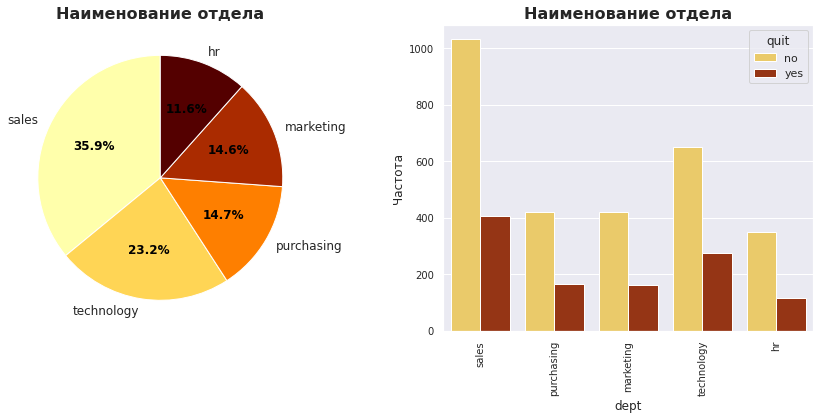

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64


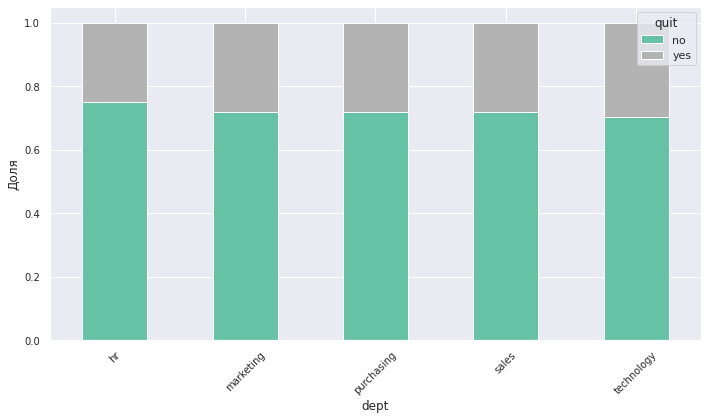

In [55]:
categorical_features(train_quit, 'dept', 'Наименование отдела', 'quit')

Как и в прошлой задаче, большая часть сотрудников работает в отделе продаж и технологическом. Увольнений в каждом из отделов от 20 до 30%. Больше всего увльнений в отделе закупок. 

quit      no   yes
level             
junior 0.485 0.515
middle 0.936 0.064
sinior 0.952 0.048


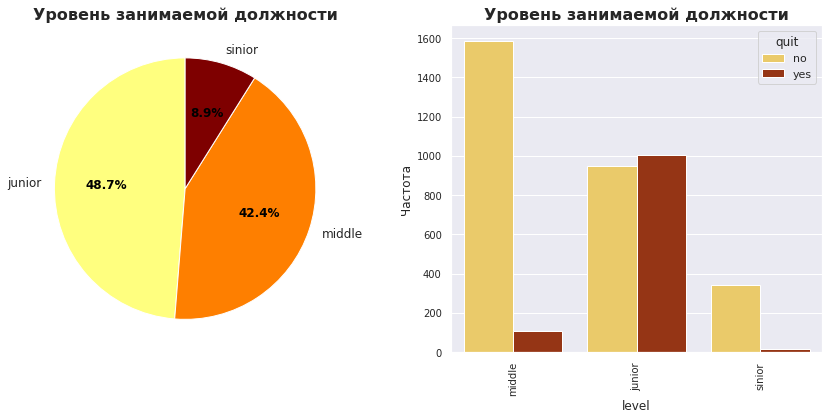

junior    1949
middle    1694
sinior     357
Name: level, dtype: int64


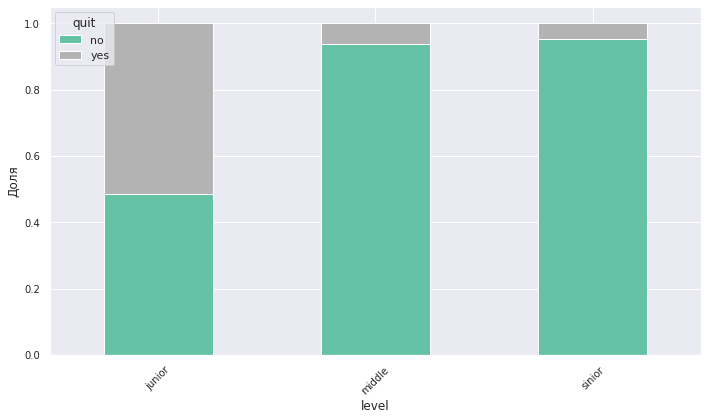

In [56]:
categorical_features(train_quit, 'level', 'Уровень занимаемой должности', 'quit')

Почти 50% сотрудников занимают позицию middle, junior 37%, меньше всего сотрудников sinior. Больше всего увольнений на позиции junior.

quit        no   yes
workload            
high     0.820 0.180
low      0.570 0.430
medium   0.770 0.230


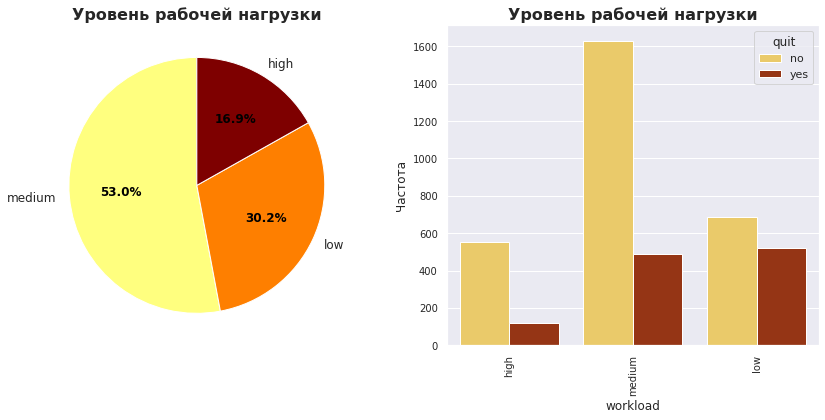

medium    2118
low       1208
high       674
Name: workload, dtype: int64


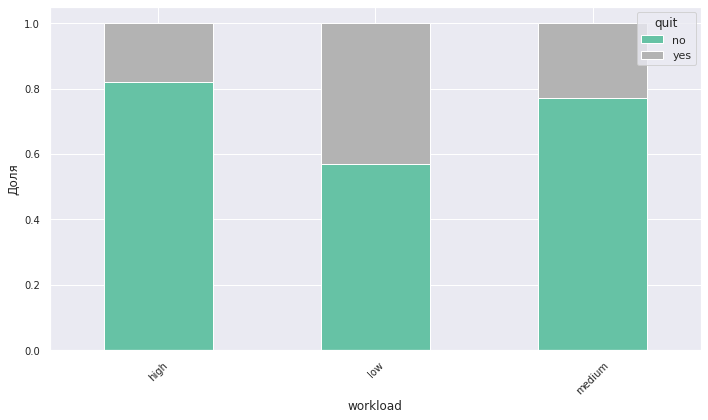

In [57]:
categorical_features(train_quit, 'workload', 'Уровень рабочей нагрузки', 'quit')

Самый популярный уровень нагрузки у сотрудников - средний. Наибольшее количество увольнений у сотрудников с низким уровнем нагрузки.

quit               no   yes
last_year_promo            
no              0.710 0.290
yes             0.991 0.009


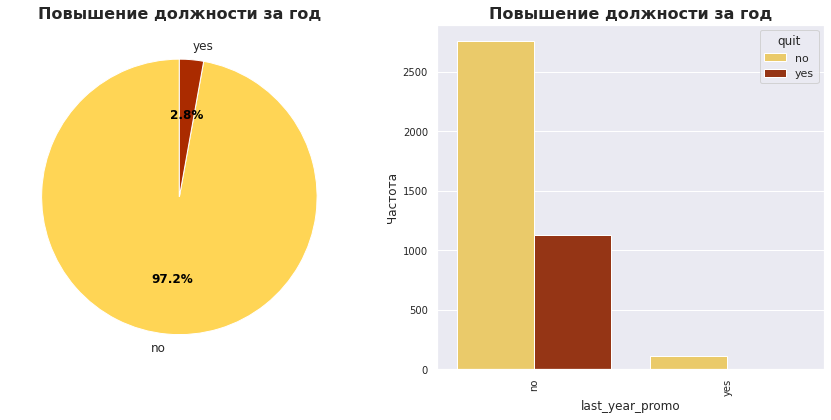

no     3887
yes     113
Name: last_year_promo, dtype: int64


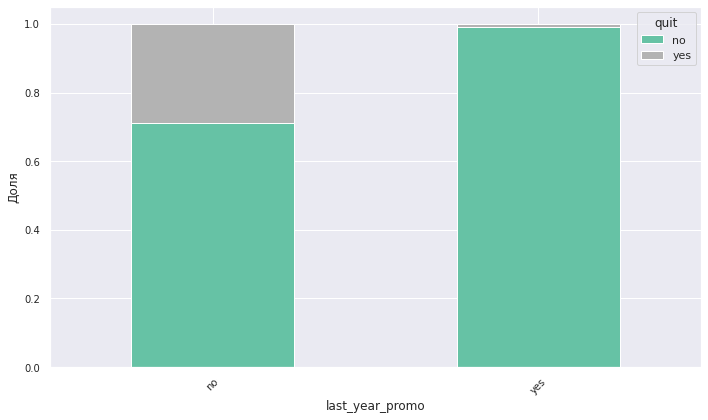

In [58]:
categorical_features(train_quit, 'last_year_promo', 'Повышение должности за год', 'quit')

Почти 96% сотрудников за последний год не получали повышения, у данной группы и наблюдаются увольнения.

quit                    no   yes
last_year_violations            
no                   0.740 0.260
yes                  0.582 0.418


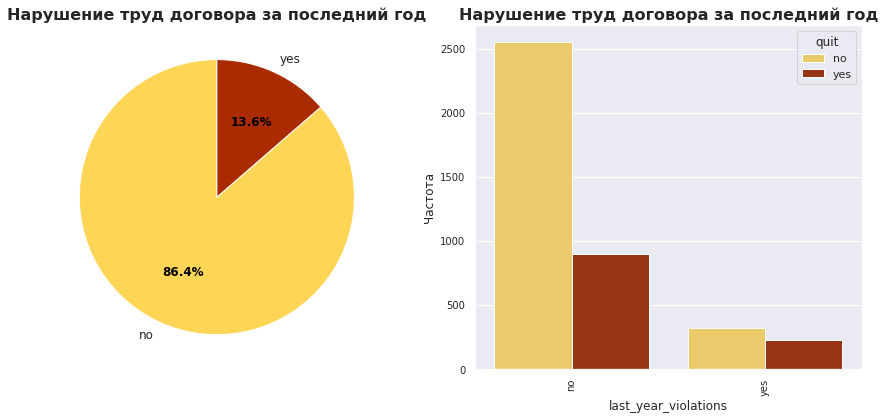

no     3455
yes     545
Name: last_year_violations, dtype: int64


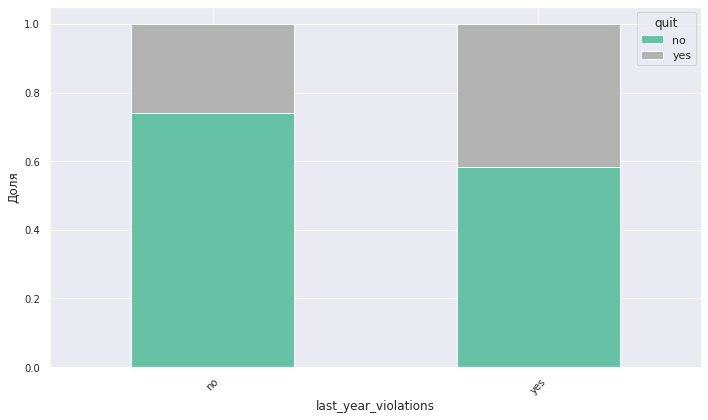

In [59]:
categorical_features(train_quit, 'last_year_violations', 'Нарушение труд договора за последний год', 'quit')

Почти 82% сотрудников за последний год не нарушали трудовой договор. Из 18.4% сотрудников нарушивших трудовой договор за последний год почти половина уволилась.

quit    no   yes
quit            
no   1.000 0.000
yes  0.000 1.000


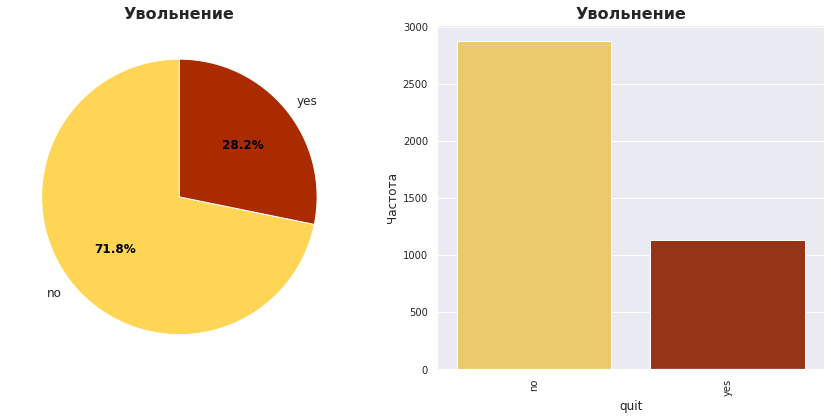

no     2872
yes    1128
Name: quit, dtype: int64


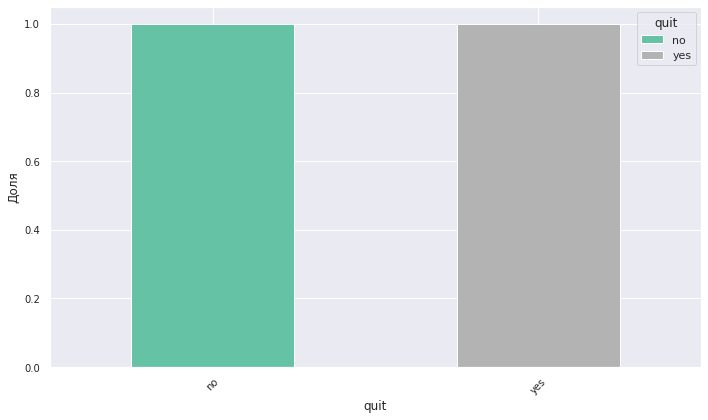

In [60]:
categorical_features(train_quit, 'quit', 'Увольнение')

Четверть сотрудников компании уволились.

**Исследование количественных признаков**

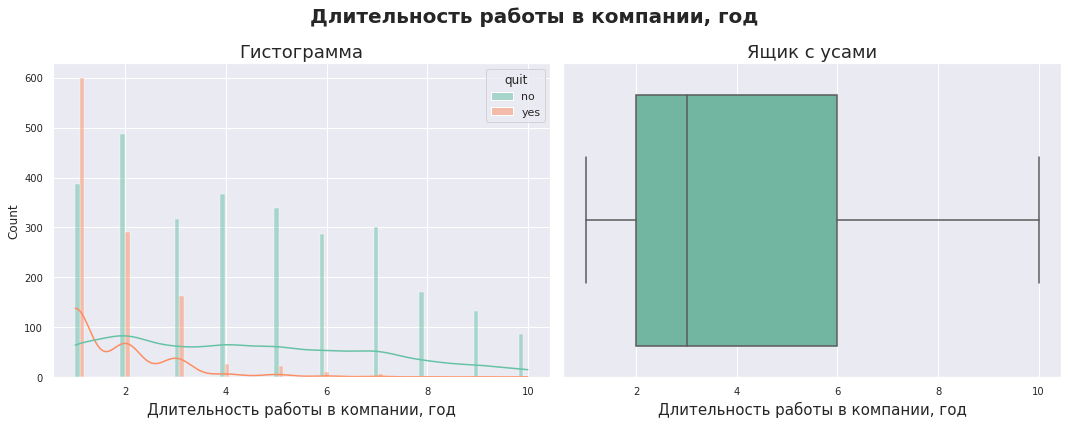

count   4,000.000
mean        3.701
std         2.542
min         1.000
25%         2.000
50%         3.000
75%         6.000
max        10.000
Name: employment_years, dtype: float64


In [61]:
quantitative_features(train_quit,'employment_years','Длительность работы в компании, год', 'quit', bins=50)

В компании наблюдается явная тенденция: большинство сотрудников работают в ней в течение четырёх или одного года. При этом более половины сотрудников, отработавших только год, принимают решение об увольнении. Однако стоит отметить, что с увеличением стажа работы в компании количество увольнений постепенно снижается.

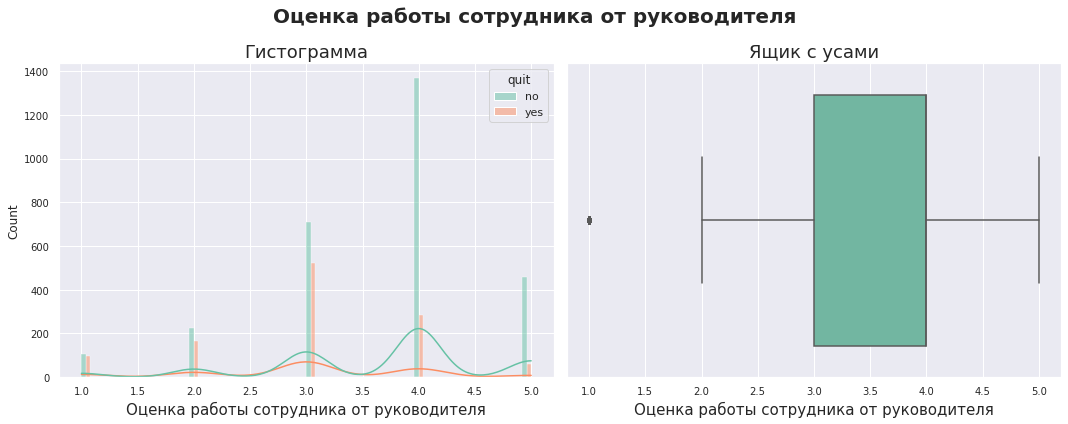

count   4,000.000
mean        3.475
std         1.004
min         1.000
25%         3.000
50%         4.000
75%         4.000
max         5.000
Name: supervisor_evaluation, dtype: float64


In [62]:
quantitative_features(train_quit,'supervisor_evaluation','Оценка работы сотрудника от руководителя', 'quit', bins=50)

Сотрудники в основном имеют оценку от руководителя в 3 или 4 бала. Наибольшее число увольнений у сотрудников получивших оценку 1. Число увольнений велико и у сотрудников получивших оценку 2 и 3. Меньше всего увольнений у сотрудников получивших оценку 4 и 5.

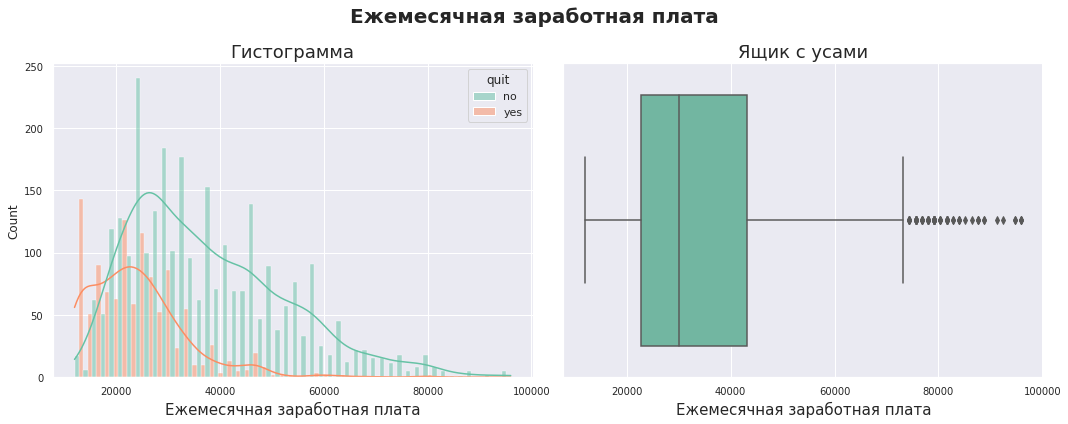

count    4,000.000
mean    33,805.800
std     15,152.415
min     12,000.000
25%     22,800.000
50%     30,000.000
75%     43,200.000
max     96,000.000
Name: salary, dtype: float64


In [63]:
quantitative_features(train_quit,'salary','Ежемесячная заработная плата', 'quit', bins=50)

Видна тендеция увольнений по ежемесячной заработной плате. Чем ниже зарплата от средней, тем больше число увольнений.

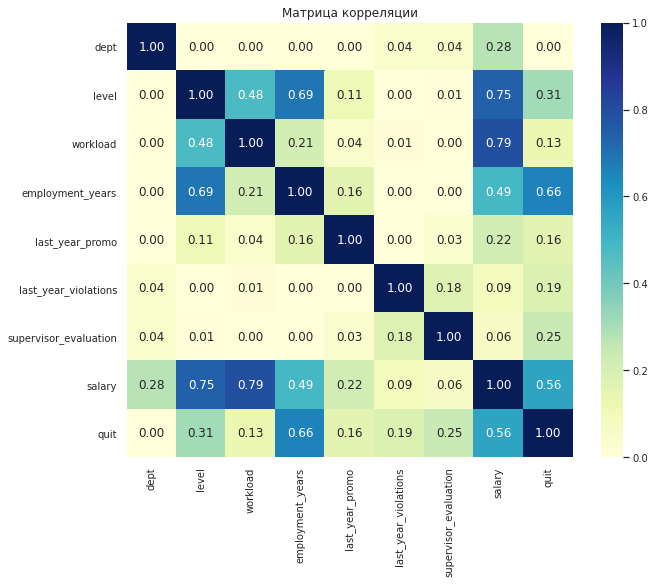

In [64]:
interval_cols = ['salary']
plt.figure(figsize=(10, 8))
sns.heatmap(train_quit.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Матрица корреляции')
plt.show()

Целевая переменная `quit` имеет сильную взаимосвязь с employment_years, среднюю взаимосвязь с salary и слабую зависимость от level, last_year_violations и supervisor_evaluation.
Признаки salary, level и workload сильно коррелируют между собой.
Будем использовать модели, устойчивые к мультиколлинеарности и способные работать с линейными и нелинейными связями: Logistic Regression (с регуляризацией L1 или L2), Decision Tree, SVC.

<Figure size 720x432 with 0 Axes>

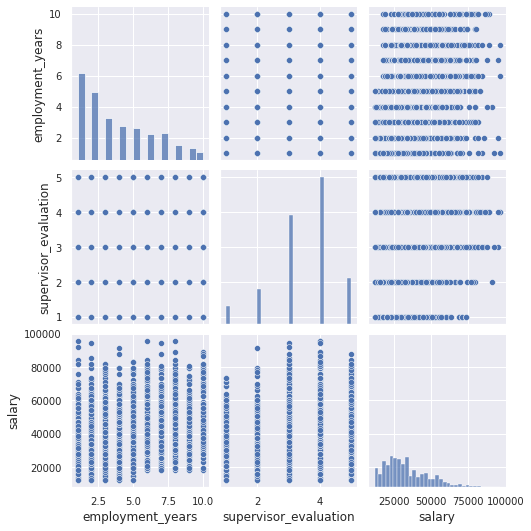

In [65]:
plt.figure(figsize=(10, 6))
sns.pairplot(train_quit, markers=["o", "s"])

plt.show()

**Итоговый портрет уволившегося сотрудника:**  
Уволившийся сотрудник — это чаще всего молодой специалист на позиции Junior в отделе закупок с низким уровнем рабочей нагрузки. Он не получал повышения за последний год, мог иметь оценку от руководителя 1–3 балла, и его зарплата была ниже средней. Также возможно, что он проработал в компании менее года и мог допустить нарушения трудового договора.

Для проверки гипотезы о том, что сотрудники с низкой зарплатой увольняются чаще, был проведён статистический анализ с использованием t-теста. Этот тест позволяет определить, существует ли значимая разница в средней зарплате между двумя группами сотрудников: уволившимися и оставшимися в компании.

Средняя зарплата уволившихся сотрудников: 23885.11
Средняя зарплата оставшихся сотрудников: 37702.23
T-статистика: -34.74, p-value: 0.0000
Различие в средней зарплате статистически значимо.


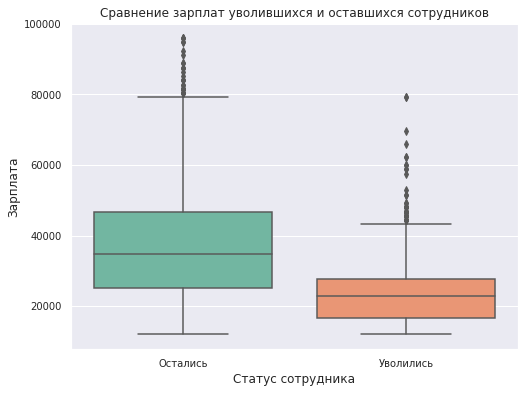

In [66]:
quit_employees = train_quit[train_quit['quit'] == 'yes']  
stayed_employees = train_quit[train_quit['quit'] == 'no']  

mean_salary_quit = quit_employees['salary'].mean()
mean_salary_stayed = stayed_employees['salary'].mean()

print(f'Средняя зарплата уволившихся сотрудников: {mean_salary_quit:.2f}')
print(f'Средняя зарплата оставшихся сотрудников: {mean_salary_stayed:.2f}')

t_stat, p_value = ttest_ind(quit_employees['salary'], stayed_employees['salary'], equal_var=False)
print(f'T-статистика: {t_stat:.2f}, p-value: {p_value:.4f}')

if p_value < 0.05:
    print("Различие в средней зарплате статистически значимо.")
else:
    print("Различие в средней зарплате не является статистически значимым.")

plt.figure(figsize=(8, 6))
sns.boxplot(x='quit', y='salary', data=train_quit, palette='Set2')
plt.xticks([0, 1], ['Остались', 'Уволились'])
plt.xlabel('Статус сотрудника')
plt.ylabel('Зарплата')
plt.title('Сравнение зарплат уволившихся и оставшихся сотрудников')
plt.show()

Результаты анализа подтвердили гипотезу о том, что низкая заработная плата является значимым фактором увольнений сотрудников. 
- Уволившиеся сотрудники получали в среднем на 15,184.23 меньше, чем те, кто остался.
- Очень низкий p-value (0.0000) говорит о том, что разница не случайна.
- Низкая зарплата может быть одним из ключевых факторов увольнения.

In [67]:
test_features.head(10)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800
429973,purchasing,middle,medium,6,no,no,3,42000
850699,technology,junior,medium,3,no,no,3,26400
500791,sales,middle,high,9,no,no,4,49200
767867,marketing,middle,high,3,no,yes,4,62400


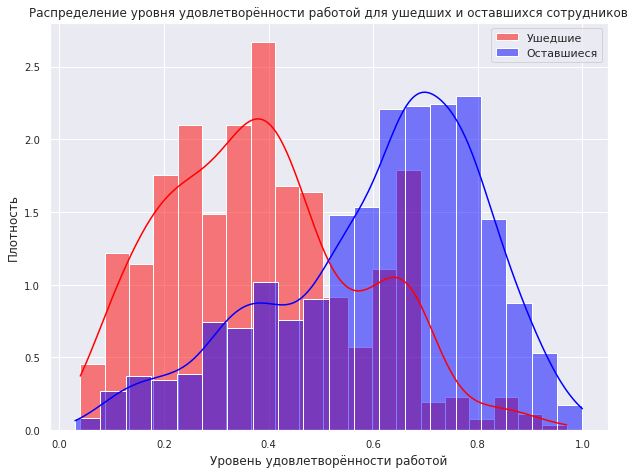

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.800,no
100480,marketing,junior,low,4,no,no,4,16800,0.840,no
100503,purchasing,middle,high,5,no,no,4,55200,0.790,no
100610,sales,middle,medium,5,no,no,4,43200,0.750,no
100692,sales,middle,high,6,no,no,4,48000,0.690,no
100710,hr,sinior,low,6,no,no,4,27600,0.680,no
100894,sales,middle,high,6,no,no,3,56400,0.490,no
102102,marketing,junior,medium,3,no,no,4,25200,0.730,no
102222,marketing,middle,medium,8,no,no,4,36000,0.660,no


In [68]:
target_quit = target_quit.sort_index()
test_features = test_features.sort_index()

test = test_features.copy()
test['job_satisfaction_rate'] = target_job['job_satisfaction_rate']
test['quit'] = target_quit['quit']


sns.histplot(test[test['quit'] == 'yes']['job_satisfaction_rate'], kde=True, color='red', label='Ушедшие', stat='density', bins=20)

sns.histplot(test[test['quit'] == 'no']['job_satisfaction_rate'], kde=True, color='blue', label='Оставшиеся', stat='density', bins=20)

plt.title('Распределение уровня удовлетворённости работой для ушедших и оставшихся сотрудников')
plt.xlabel('Уровень удовлетворённости работой')
plt.ylabel('Плотность')
plt.legend()

plt.show()
test.head(10)

Увольняются в основном сотрудники, удовлетворенность работой которых ниже 0.6.

#### Промежуточный вывод

**Цель:** провести исследовательский анализ данных.  
**Задачи:**
1. Исследовать количественные и категориальные принаки.
2. Составить портрет уволившегося сотрудника.
3. Оценить влияние заработной платы и удовлетворенности сотрудников на увольнение.

**Результаты**

1) Исследовать количественные и категориальные принаки: 
- Проведен исследовательский анализ количественных и категориальных признаков по целевому.
- Для расчета корреляции применялся коэффициент Фи так как среди признаков имелись категориальные. Выявлена сильная зависимость целевого признака от employment_years, и средняя взаимосвязь с salary.

2) Составить портрет уволившегося сотрудника:
- Уволившийся сотрудник — это специалист на позиции Junior в отделе закупок и низким уровнем рабочей нагрузки. Он не получал повышения за последний год, мог иметь оценку от руководителя 1–3 балла, и его зарплата была ниже средней.

3) Оценить влияние заработной платы и удовлетворенности сотрудников на увольнение
- Гипотеза о том, что сотрудники с низкой зарплатой увольняются чаще, была подтверждена при помощи t-теста. 
- Увольняются в основном сотрудники, удовлетворенность работой которых ниже 0.6.

## Шаг 4.  Добавление нового вводного признака.

Так как в прошлом шаге мы установили, что целевой признак `quit` имеет зависимость от `job_satisfaction_rate`, то нужно внести предсказание `job_satisfaction_rate` во входные признаки.

In [69]:
train_quit['job_satisfaction_rate']= grid.best_estimator_.predict(train_quit)
test_features['job_satisfaction_rate'] = grid.best_estimator_.predict(test_features)

display(train_quit.head(5), test_features.head(5))
train_quit.info()
test_features.info()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.618
814010,sales,junior,medium,2,no,no,4,27600,no,0.854
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.327
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340
910140,marketing,junior,medium,2,no,no,5,25200,no,0.792


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.832
100480,marketing,junior,low,4,no,no,4,16800,0.852
100503,purchasing,middle,high,5,no,no,4,55200,0.788
100610,sales,middle,medium,5,no,no,4,43200,0.804
100692,sales,middle,high,6,no,no,4,48000,0.713


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   quit                   4000 non-null   object 
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 472.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100298 to 999029
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 -----

In [70]:
X_test.index[:5], test_features.index[:5]

(Int64Index([485046, 686555, 467458, 418655, 789145], dtype='int64', name='id'),
 Int64Index([100298, 100480, 100503, 100610, 100692], dtype='int64', name='id'))

Новый признак успешно добавлен.

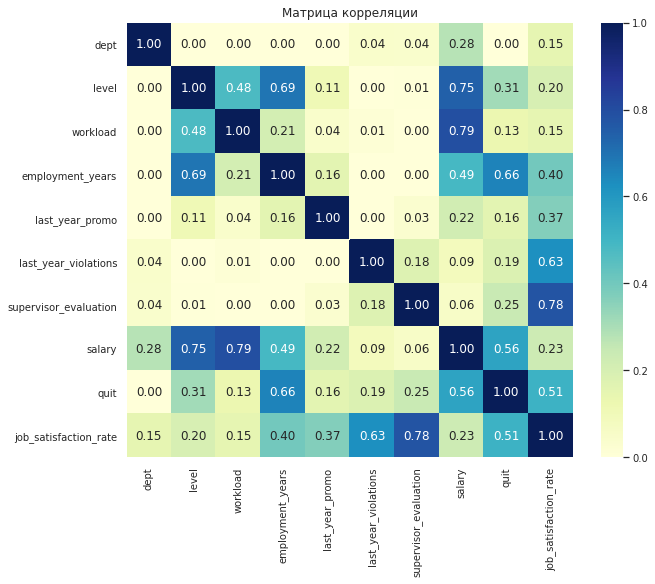

In [71]:
interval_cols = ['salary', 'job_satisfaction_rate']
plt.figure(figsize=(10, 8))
sns.heatmap(train_quit.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Матрица корреляции')
plt.show()

По матрице корреляции видна умеренная зависимость между целевым признаком и уровнем довольности сотрудников на тренировочной выборке.

#### Промежуточный вывод

**Цель:** Добавить новый признак.  
**Задачи:**
1. Предсказать признак.
2. Добавить новый признак.

**Результаты**

1) Предсказать признак: 
-  При помощи модели был предсказан `job_satisfaction_rate` для входных признаков.

2) Добавить новый признак:
- В датафреймы `train_quit` и `test_features` добавлен столбец с предсказанным уровнем довольства сотруников.
- Корреляция между уровнем удовольствия сотрудников и увольнением имеет удовлетворительный уровень.

## Шаг 5. Подготовка данных.

Первым делом создадим списки для кодирования и масштабирования данных. Целевой признак не нужно кодировать или масштабировать, так как он уже находится в подходящем диапазоне и соответствует требованиям регрессионных моделей. Для категориальных признаков будем использовать OneHotEncoder и OrdinalEncoder, для количественных MinMaxScaler и StandartScaler. Так же нам нужно заполнить пропуски SimpleImputer. Уточним, что у нас имеется дисбаланс классов целевого признака `quit`. Во время исследовательского анализа было установлено, что уволилось 25.3% сотрудников, не уволились 74.7% пользователя. Используем кодирование целевого признака Label Encoder.

In [72]:
ohe_columns = [
    'dept', 
    'last_year_promo',
    'last_year_violations'
]
ord_columns = [
    'level',
    'workload'
]
num_columns = [
    'supervisor_evaluation',
    'job_satisfaction_rate',
    'employment_years',
    'salary'
]

Оформим выборки.

In [73]:
X_train_q = train_quit.drop('quit', axis=1)
y_train_q = train_quit['quit']

test_data = test_features.merge(target_quit, on='id')

X_test_q = test_data.drop('quit', axis=1)
y_test_q = test_data['quit']

encoder = LabelEncoder()

y_train_q_encoded = encoder.fit_transform(y_train_q)

y_test_q_encoded = encoder.transform(y_test_q)

print(X_train_q.shape)
print(X_test_q.shape)
print(y_train_q.shape)
print(y_test_q.shape)

(4000, 9)
(2000, 9)
(4000,)
(2000,)


Проверим как закодирован целевой признак.

In [74]:
original_labels = encoder.inverse_transform([0, 1])

print(f"Значение для 0: {original_labels[0]}")
print(f"Значение для 1: {original_labels[1]}")

Значение для 0: no
Значение для 1: yes


#### Промежуточный вывод

**Цель:** провести подготовку данных.  
**Задачи:**
1) Применить кодирование и масштабирование.   
2) Создать пайплайн.

**Результаты**
1) Применить кодирование и масштабирование:
- Для категориальных признаков применены кодировщики OneHotEncoder и OrdinalEncoder.
- Для количественных признаков применено масштабирование StandardScaler и MinMaxScaler.
- Проведено разбитие выборок на тестовую и тренирововчную соответсвующей размерности.
- Целевой признак закодирован LabelEncoder.

2) Создать пайплайн:
- Создан пайплайн data_preprocessor c SimpleImputer для заполнения пропусков у категориальных данных модой.

## Шаг 6. Обучение модели.

Обучим модель. Попробуем три модели: **DecisionTreeClassifier** c гиперпараметрами - минимальное количество образцов, необходимое для нахождения в листовом узле каждого дерева, минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться, максимальную глубина дерева. **LogisticRegression** c гиперпараметрами - ридж или лассо -регуляризацией  и настройка С-коэффициент. **KNeighborsClassifier** c гиперпараметрами - так же количество соседей. Так как в нашей выборке дисбаланс классов то для моделей **SVC** и **LogisticRegression** применим взвешивание классов.   
**Выбор метрики.** Перед нами задача для бинарной классификации. Оценку лучшей модели будем проводить по метрике ROC-AUC так как данная метрика оценивает способность модели различать классы на всех возможных порогах классификации и не чувствительна к дисбалансу классов. 

In [75]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('classifier', LogisticRegression())
    ]
) 

param_grid = [
    {
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'], 
        'classifier': [LogisticRegression(random_state=42, solver='liblinear', max_iter=1000, class_weight='balanced')],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1']
    },
    {
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough'],
        'classifier': [DecisionTreeClassifier(random_state=42)],
        'classifier__min_samples_leaf': [1, 10],
        'classifier__min_samples_split': [2, 10],
        'classifier__max_depth': [2, 20]
    },
    {
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': range(10, 25),  
    }
]

grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid.fit(X_train_q, y_train_q_encoded)
best_model = grid.best_estimator_

print(f'Лучшие параметры: {grid.best_params_}')
print(f'Лучшая модель: {best_model}')
print(f'Лучший ROC-AUC: {grid.best_score_:.4f}')

Лучшие параметры: {'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 21, 'preprocessor__num': StandardScaler()}
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                    

In [76]:
y_test_pred = grid.predict_proba(X_test_q)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_q_encoded, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.9148331160236275


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


С первого раза получили достойное значение метрики. Лучшей моделью является **метод ближайших соседей** с гиперпараметром 'classifier__n_neighbors': **21** и масштабированием численных признаков StandardScaler(). Метрика **ROC-AUC** на тестовой выборке составила **0.914**.

#### Промежуточный вывод

**Цель:** Обучить и выбрать лучшую модель.  
**Задачи:**
1. Определить модели и их гиперпараметры.
2. Обучить модели.
3. Выбрать лучшую модель.

**Результаты**

1) Определить модели и их гиперпараметры: 
- Выбрана модель логистической регрессии c гиперпараметрами - ридж-регуляризация или лассо и настройка С-коэффициент.
- Выбрана модель дерева решений с подборов гиперпараметров:минимальное количество образцов, необходимое для нахождения в листовом узле каждого дерева, минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться, максимальную глубина дерева.
- Выбрана модель ближайших соседей с настройкой количества соседей.
- Использованы весы для обхода дисбаланса классов.

2) Обучить модели:
- Обученые модели оценивались метрикой ROC-AUC, лучшие результаты на тренировочной выборке показала модель дерева решений  0.9148.

3) Выбрать лучшую модель:
- Лучшая модель это метод ближайших соседей с числом соседей равное 21 и масштабированием численных признаков с помощью StandartScaler().

# Общий вывод

В данном проекте было выполнено 2 задачи. **Первая** заключалась в создании модели, прогнозирующей уровень удовлетворенности сотрудников на основе данных, предоставленных заказчиком.
**Вторая** задача состояла в разработке модели, способной предсказать вероятность увольнения сотрудника, используя существующие данные. Это дает возможность оперативно выявлять сотрудников, находящихся в зоне риска, и принимать превентивные меры для их удержания.

**Для успешного выполнения обеих задач были реализованы следующие этапы:**

1) Загрузка и первичный анализ данных: На этом этапе мы познакомились с предоставленными данными, выявили ключевые признаки и их значимость для дальнейшего анализа.

2) Предобработка данных: Включала проверку на наличие пропусков и дубликатов, и их устранение, что обеспечило чистоту и корректность данных.

3) Исследовательский анализ данных (EDA): Здесь мы визуализировали данные и проанализировали корреляционные связи между переменными, что помогло понять основные тенденции и закономерности.

4) Подготовка данных к моделированию: На этом этапе были созданы пайплайны для кодирования категориальных признаков и масштабирования числовых данных, чтобы обеспечить правильное формирование модели.

5) Обучение моделей: Выбор оптимальных моделей, применения методов масштабирования и настройки гиперпараметров с целью достижения наилучших результатов:


    - *Для первой задачи* по метрике SMAPE равной на тестовой выборке 13.66% лучшей моделью стала Decision Tree с параметрами model__max_depth': None, model__min_samples_leaf: 1, model__min_samples_split: 9.
    - *Для второй задачи* по метрике ROC-AUC рафной 0.9148 лучшей моделью стала KNeighborsClassifier с параметрами ближайших соседей равной 21.

**На основе анализа были выработаны несколько рекомендаций для бизнеса, направленных на снижение текучести кадров:**

- Внедрить программы наставничества и менторства для молодых специалистов уровня Junior, особенно в отделе закупок чтобы снизить стресс и рабочую нагрузку.

- Разработать прозрачную систему карьерного роста и регулярно проводить оценки эффективности сотрудников для своевременного повышения.

- Пересмотреть систему вознаграждений и премий с целью повышения конкурентоспособности заработной платы, особенно для начинающих сотрудников.

- Проводить регулярные анонимные опросы удовлетворенности работой, чтобы оперативно выявлять и устранять проблемы.

- Внедрить программы по снижению стресса и управлению рабочей нагрузкой, включая гибкие графики и дополнительные дни отдыха.

- Контролировать соблюдение трудовых прав и условий работы, особенно для сотрудников с коротким стажем, чтобы снизить риск нарушений трудового договора.